In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import KMNIST
# from Model.CustomLene import CustomLenet
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from collections import Counter
from pytorch_utils import get_device
from model import CustomLenet



In [2]:
# # Hiperparametros
# lr = 0.001
# batch_size = 64
# epochs = 30
device = get_device()
# train_split = 0.9
path_db = "rice"
transformaciones = transforms.ToTensor()
DB = datasets.ImageFolder(path_db, transform=transformaciones)
DB_size = len(DB)

CUDA


In [3]:
def media_std(path_db, batch_size=64, workers=4):
    transformaciones = transforms.ToTensor()
    DB = datasets.ImageFolder(path_db, transform=transformaciones)
    DB_loader = DataLoader(DB, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=False)
    
    media = 0.0
    std = 0.0
    
    # Initialize the counter here
    imgs_totales = 0
    
    for imagenes, _ in DB_loader:
        batch_samples = imagenes.size(0)
        imagenes = imagenes.view(batch_samples, imagenes.size(1), -1)
        media += imagenes.mean(2).sum(0)
        std += imagenes.std(2).sum(0)
        imgs_totales += batch_samples

    media /= imgs_totales
    std /= imgs_totales
    print(f'[INFO] Imagenes revisadas: {imgs_totales}')
    return media, std

In [4]:
mu, std = media_std(path_db)
print(f"[INFO] Media:{mu}, Desviacion EStandar:{std}")

[INFO] Imagenes revisadas: 45000
[INFO] Media:tensor([0.1339, 0.1344, 0.1389]), Desviacion EStandar:tensor([0.3030, 0.3041, 0.3172])


In [5]:
# hiperparametros
batch_size = 64
epochs = 60
lr = 0.001
train_split = 0.8
val_split = 0.1
test_split = 0.1
momentum = 0.9
weaight_decay = 5e-4

# Preprocesamiento

transformaciones = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean = [0.1339, 0.1344, 0.1389],std = [0.3030, 0.3041, 0.3172] )  
])

DB = datasets.ImageFolder(path_db, transform=transformaciones)
total_size = len(DB)
labels = [label for _, label in DB]
class_counts = Counter(labels)

for id, cls_name in enumerate(DB.classes):
    print(f'[INFO] Clase {cls_name} tine {class_counts[id]} imagenes')

[INFO] Clase Basmati tine 15000 imagenes
[INFO] Clase Ipsala tine 15000 imagenes
[INFO] Clase Karacadag tine 15000 imagenes


In [6]:
train_size = int(train_split * total_size)
val_size   = int(val_split * total_size)
test_size  = total_size - train_size - val_size


train_data, val_data, test_data = random_split(DB, [train_size, val_size, test_size],
                                               generator= torch.Generator().manual_seed(42))

trainDataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valDataLoader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
testDataLoader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"[INFO] Tamaño del set de entrenamiento: {len(train_data)}")
print(f"[INFO] Tamaño del set de val: {len(val_data)}")
print(f"[INFO] Tamaño del set de test: {len(test_data)}")
print(f"[INFO] Numero de clases: {len(DB.classes)}")

[INFO] Tamaño del set de entrenamiento: 36000
[INFO] Tamaño del set de val: 4500
[INFO] Tamaño del set de test: 4500
[INFO] Numero de clases: 3


In [7]:
from model import CustomLenet
import torchsummary

print("[INFO] Inicializando  el modelo ...")
model = CustomLenet(nChannels=3, nClasses=len(DB.classes))
model = model.to(device)
print(trainDataLoader.dataset[0][0].shape)
print(model)
summary = torchsummary.summary(model, input_size = trainDataLoader.dataset[0][0].shape)

[INFO] Inicializando  el modelo ...
torch.Size([3, 250, 250])
CustomLenet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=30752, out_features=32, bias=True)
  (dropout_fc1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 248, 248]           2,432
              ReLU-2         [-1, 32, 248, 248]               0
         MaxPool2d-3         [-1, 32, 124, 124]               0
            Conv2d-4          [-1, 8, 124, 124]           2,312
              ReLU-5          [-1, 8, 124, 124]     

In [8]:
# optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay=weaight_decay, momentum=momentum)
# criterion = torch.nn.CrossEntropyLoss()
# history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[] }

# for e in range(0,epochs):
#     model.train()
#     total_train_loss = 0.0
#     total_val_loss = 0.0

#     train_correct = 0.0
#     val_correct = 0.0

#     for imgs, labels in trainDataLoader:
#         (imgs, labels) = (imgs.to(device), labels.to(device))
#         preds          = model(imgs)
#         loss           = criterion(preds, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_train_loss += loss
#         train_correct    += (preds.argmax(dim=1) == labels).type(torch.float).sum().item()

#     with torch.no_grad():
#         model.eval()
#         for val_imgs, val_labels in valDataLoader:
#             val_imgs, val_labels = (val_imgs.to(device), val_labels.to(device))
#             preds_vals = model(val_imgs)

#             total_val_loss  = criterion(preds_vals, val_labels)
#             val_correct    += (preds_vals.argmax(dim=1) == val_labels).sum().type(torch.float) 

#     avg_train_loss = total_train_loss / (len(trainDataLoader.dataset)// batch_size)
#     avg_val_loss   = total_val_loss / (len(valDataLoader.dataset) // batch_size)
#     avg_train_acc  = train_correct / len(trainDataLoader.dataset)
#     avg_val_acc    = val_correct / len(valDataLoader.dataset)

#     history['train_loss'].append(avg_train_loss.detach().cpu().numpy())
#     history['train_acc'].append(avg_train_acc)
#     history['val_loss'].append(avg_val_loss.detach().cpu().numpy())
#     history['val_acc'].append(avg_val_acc.detach().cpu().numpy())

#     print(f'[info] Epoch:{e+1}/{epochs} | Train Loss:{avg_train_loss:.4f} | Train acc:{avg_train_acc:.4f} | Val Loss:{avg_val_loss:.4f} | Val acc:{avg_val_acc:.4f} ')
#     torch.cuda.empty_cache()  # Free unused GPU memory after each epoch


In [9]:
import copy
import numpy as np
import torch

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weaight_decay, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()

history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[] }

# --- Early Stopping params ---
patience = 10               # número de épocas sin mejora antes de parar
best_val_loss = np.inf
counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

for e in range(epochs):
    model.train()
    total_train_loss = 0.0
    total_val_loss = 0.0

    train_correct = 0.0
    val_correct = 0.0

    # ---- TRAIN LOOP ----
    for imgs, labels in trainDataLoader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_correct    += (preds.argmax(dim=1) == labels).type(torch.float).sum().item()

    # ---- VALIDATION LOOP ----
    model.eval()
    with torch.no_grad():
        for val_imgs, val_labels in valDataLoader:
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
            preds_vals = model(val_imgs)
            loss_val = criterion(preds_vals, val_labels)

            total_val_loss += loss_val.item()
            val_correct    += (preds_vals.argmax(dim=1) == val_labels).type(torch.float).sum().item()

    # ---- METRICS ----
    avg_train_loss = total_train_loss / len(trainDataLoader)
    avg_val_loss   = total_val_loss / len(valDataLoader)
    avg_train_acc  = train_correct / len(trainDataLoader.dataset)
    avg_val_acc    = val_correct / len(valDataLoader.dataset)

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)

    print(f'[INFO] Epoch:{e+1}/{epochs} | Train Loss:{avg_train_loss:.4f} | Train Acc:{avg_train_acc:.4f} | Val Loss:{avg_val_loss:.4f} | Val Acc:{avg_val_acc:.4f}')

    # ---- EARLY STOPPING + SAVE BEST MODEL ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")
        print(f"    🔥 Mejor modelo guardado con Val Loss: {best_val_loss:.4f}")
        counter = 0
    else:
        counter += 1
        print(f"    ⚠️ No mejora en {counter}/{patience} épocas")

    if counter >= patience:
        print("⏹️ Early stopping activado.")
        break

    torch.cuda.empty_cache()  # liberar memoria GPU


[INFO] Epoch:1/60 | Train Loss:0.0607 | Train Acc:0.9695 | Val Loss:0.0035 | Val Acc:0.9989
    🔥 Mejor modelo guardado con Val Loss: 0.0035
[INFO] Epoch:2/60 | Train Loss:0.0026 | Train Acc:0.9992 | Val Loss:0.0025 | Val Acc:0.9993
    🔥 Mejor modelo guardado con Val Loss: 0.0025
[INFO] Epoch:3/60 | Train Loss:0.0017 | Train Acc:0.9995 | Val Loss:0.0025 | Val Acc:0.9996
    ⚠️ No mejora en 1/10 épocas
[INFO] Epoch:4/60 | Train Loss:0.0008 | Train Acc:0.9999 | Val Loss:0.0026 | Val Acc:0.9991
    ⚠️ No mejora en 2/10 épocas
[INFO] Epoch:5/60 | Train Loss:0.0006 | Train Acc:0.9999 | Val Loss:0.0018 | Val Acc:0.9993
    🔥 Mejor modelo guardado con Val Loss: 0.0018
[INFO] Epoch:6/60 | Train Loss:0.0007 | Train Acc:0.9997 | Val Loss:0.0022 | Val Acc:0.9993
    ⚠️ No mejora en 1/10 épocas
[INFO] Epoch:7/60 | Train Loss:0.0003 | Train Acc:0.9999 | Val Loss:0.0018 | Val Acc:0.9993
    🔥 Mejor modelo guardado con Val Loss: 0.0018
[INFO] Epoch:8/60 | Train Loss:0.0006 | Train Acc:0.9998 | Val L

In [10]:
model.load_state_dict(best_model_wts)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for val_imgs, val_labels in testDataLoader:
        val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
        preds_vals = model(val_imgs)
        preds_classes = preds_vals.argmax(dim=1)

        all_preds.extend(preds_classes.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

from sklearn.metrics import f1_score
val_macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f"[INFO] Macro-F1 del mejor modelo: {val_macro_f1:.4f}")

[INFO] Macro-F1 del mejor modelo: 0.9998


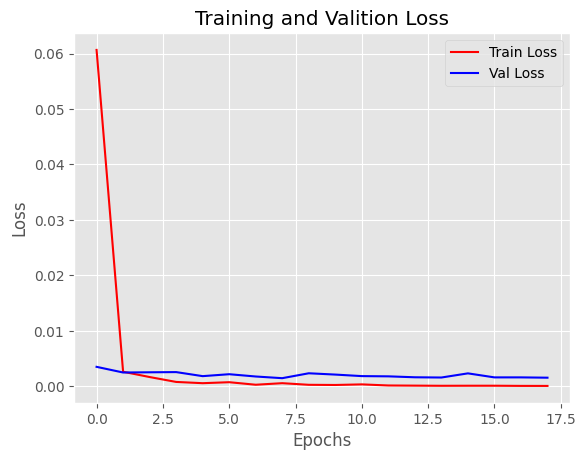

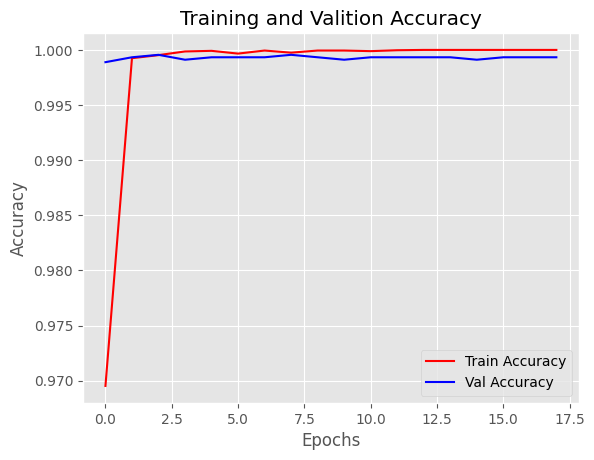

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure()
plt.plot(history['train_loss'], label= 'Train Loss', color = 'red')
plt.plot(history['val_loss'], label= 'Val Loss', color = 'blue')
plt.title('Training and Valition Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 0)
plt.grid(True)
plt.show


plt.figure()
plt.plot(history['train_acc'], label= 'Train Accuracy', color = 'red')
plt.plot(history['val_acc'], label= 'Val Accuracy', color = 'blue')
plt.title('Training and Valition Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 0)
plt.grid(True)
# plt.showtestData


In [13]:
print('[Info] Testing the model')
with torch.no_grad():
    model.eval()
    probs = []
    true_labels = []

    for test_imgs, test_labels in testDataLoader:
        test_imgs, test_labels = (test_imgs.to(device), test_labels.to(device))
        output = model(test_imgs)
        preds = output.argmax(dim=1)
        probs.extend(preds.cpu().numpy())
        true_labels.extend(test_labels.cpu().numpy())

from sklearn.metrics import classification_report

print(classification_report(true_labels, np.array(probs), target_names=DB.classes))



[Info] Testing the model
              precision    recall  f1-score   support

     Basmati       1.00      1.00      1.00      1515
      Ipsala       1.00      1.00      1.00      1488
   Karacadag       1.00      1.00      1.00      1497

    accuracy                           1.00      4500
   macro avg       1.00      1.00      1.00      4500
weighted avg       1.00      1.00      1.00      4500



In [14]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Crear la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # Si no se pasan nombres de clases, usar índices
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]

    # Visualización con seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm




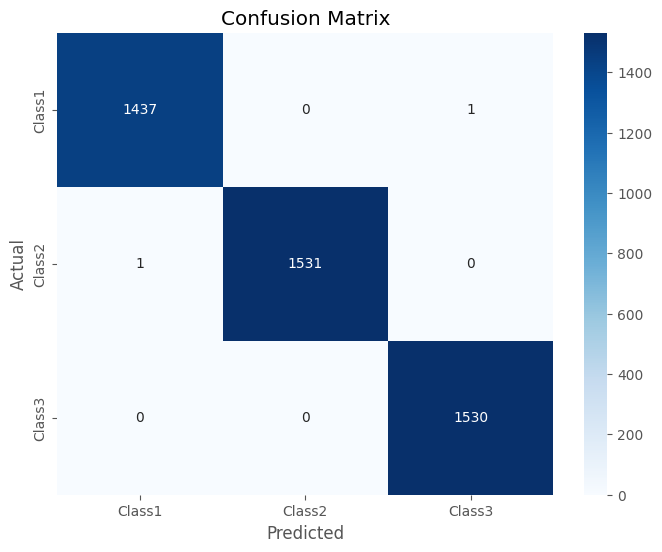

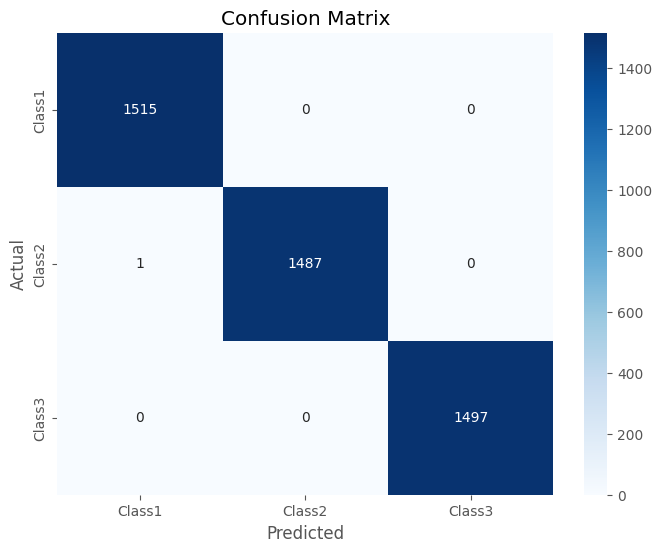

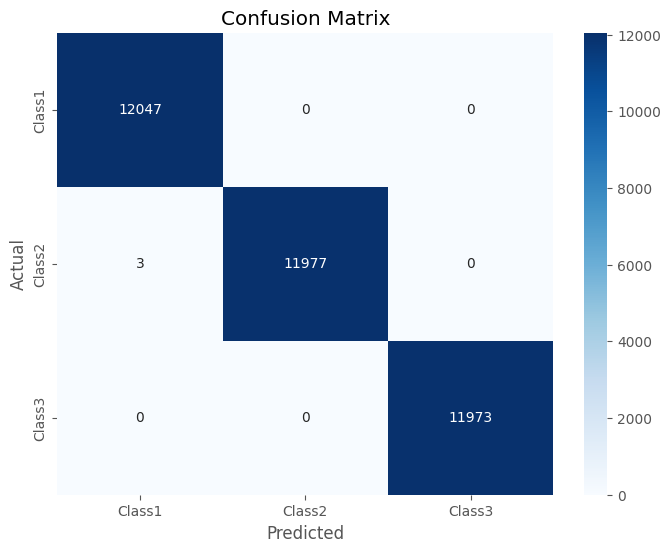

In [15]:
cm = plot_confusion_matrix(model, valDataLoader, device, class_names=['Class1','Class2','Class3'])
cm = plot_confusion_matrix(model, testDataLoader, device, class_names=['Class1','Class2','Class3'])
cm = plot_confusion_matrix(model, trainDataLoader, device, class_names=['Class1','Class2','Class3'])

In [ ]:

import torch.nn 
from torch.nn import Module, Conv2d, Linear, MaxPool2d,  ReLU, BatchNorm1d, BatchNorm2d,  Dropout
from torch import flatten


class CustomLenet(Module):

    def __init__(self, nChannels, nClasses):
        super(CustomLenet, self).__init__()
        self.conv1 = Conv2d(nChannels, 32, kernel_size=5, stride=1, padding=1)
        # self.bn1 = BatchNorm2d(32)
        self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.bn2 = BatchNorm2d(64)
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)
        self.relu = ReLU()
        
        self.fc1 = Linear(62 * 62 * 64, 256)
        # self.bn3 = BatchNorm1d(256)
        self.dropout_fc1 = Dropout(0.5)
        self.fc2 = Linear(256, 128)
        # self.bn4 = BatchNorm1d(128)
        # self.dropout_fc2 = Dropout(0.5)
        self.fc3 = Linear(128, nClasses)
       

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        # x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = flatten(x, 1)

        x = self.fc1(x)
        # x = self.bn3(x)
        # x = self.dropout_fc1(x)

        x = self.fc2(x)
        # x = self.bn4(x)
        # x = self.dropout_fc2(x)

        x = self.fc3(x)
        return x
    